# Introduction

## What is OMR?

**Optical Mark Recognition** (**OMR**) is the process of capturing human-marked data from document forms such as surveys and tests.
This technique can read marks that have been made in predefined positions (eg, "bubbles" to be filled in, boxes to be checked off) on paper forms.[1]

We have two professional approaches to do OMR:

- Use a hardware device that detects a reflection or limited light transmittance on or through a piece of paper.
- Use a OMR software to capture data from a scanned document.

## Problem

Our resources are limited (e.g: money, demand, environment), and we need to find optimized approaches. An other approach is instead of using a scanner to capture data, we use a real camera (e.g: phone camera) to take document images and capture data on taken images.

The different between **document image from scanner (A)** and **document image from real camera (B)** is described in this example:

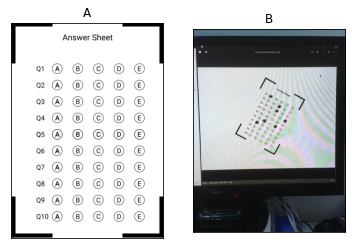

In [1]:
import cv2
from matplotlib import pyplot as plt

standard_image =  cv2.imread('data/sheet.png')
nonstandard_image = cv2.imread('data/answered-sheet.jpg')

plt.subplot(121),plt.imshow(standard_image), plt.title('A')
plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(nonstandard_image), plt.title('B')
plt.xticks([]), plt.yticks([])
plt.show()

## Idea

To capture data from a real camera, we do steps:

- Convert input image to grayscale.
- Remove high frequency content.
- Apply threshold
- Find contours
- Find corners among all contours
- Find outmost points of all corners
- Apply perpsective transform
- Scan each line for the marked answer

## Definition

**Filter:** A routine that changes the appearance of an image or part of an image by altering the shades and colors of the pixels.

## Helpers

**Draw 2D data:**

In [2]:
from matplotlib import cm
import numpy as np


def draw_2d_data(data, step=1):
    X, Y = np.meshgrid(np.arange(0, data.shape[0], step),
                       np.arange(0, data.shape[1], step))
    figure = plt.figure()
    ax = figure.add_subplot(111, projection='3d')
    surface = ax.plot_surface(X, Y, data,
                              cmap=cm.coolwarm,
                              linewidth=0,
                              antialiased=False)
    figure.colorbar(surface)
    plt.show()

**Draw image inside a grid:**

In [3]:
def draw_image(position, image, name):
    plt.subplot(position)
    plt.imshow(image)
    plt.title(name)
    plt.xticks([])
    plt.yticks([])

# Remove high frequency content

## Overview

High frequency content means pixel values that are rapidly changing in space, for example: noise. Our approach depends on found contours, so we should remove useless pixels to find contours in an image exactly.

## Methods

### Averaging

This method simply takes the average of all the pixels under the filter (or kernel) area and replaces the central element. For example:

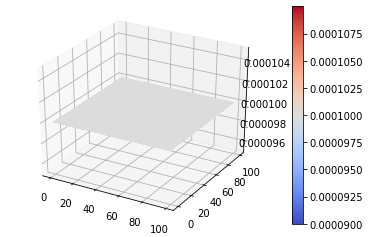

In [4]:
from matplotlib import cm
import numpy as np


def create_averaging_filter(filter_size):
    return np.ones(filter_size, np.float32) / (filter_size[0] * filter_size[1])


# Create and draw averaging filter using size (100, 100)
draw_2d_data(create_averaging_filter((100, 100)))

### Gaussian Blurring

In this method, we use a Gaussian filter to remove high frequency content. Gaussian blurring is highly effective in removing Gaussian noise (noise can be approximated by a **normal distribution**) from an image.

This script explains how to create a Gaussian filter using OpenCV:

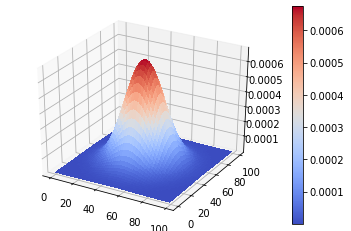

In [5]:
from matplotlib import cm


def create_gaussian_filter(filter_size):
    filter_x = cv2.getGaussianKernel(filter_size[0], 0)
    filter_y = cv2.getGaussianKernel(filter_size[1], 0)
    return filter_x @ filter_y.transpose()


# Create and draw Gausian filter using size (100, 100)
draw_2d_data(create_gaussian_filter((100, 100)))

### Median Blurring

In this method, we take the median of all the pixels under the kernel area and the central element is replaced with the median value. This method is used to reduce salt-and-pepper noise in an image. For example:

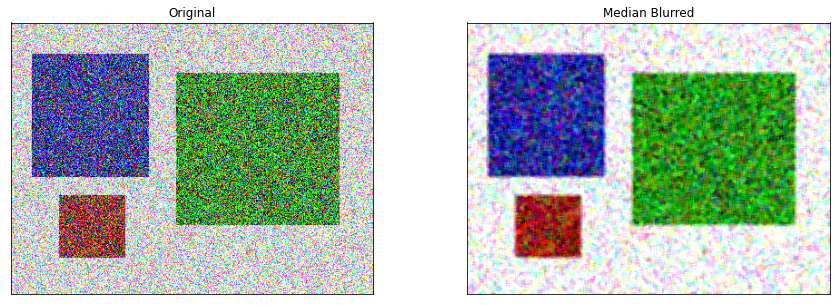

In [6]:
noised_image = cv2.imread('data/pic2.png')

median_blurred_image = cv2.medianBlur(noised_image, 5)
plt.rcParams['figure.figsize'] = [15, 5] # default: [6, 4]
draw_image(121, noised_image, 'Original')
draw_image(122, median_blurred_image, 'Median Blurred')

## Comparison

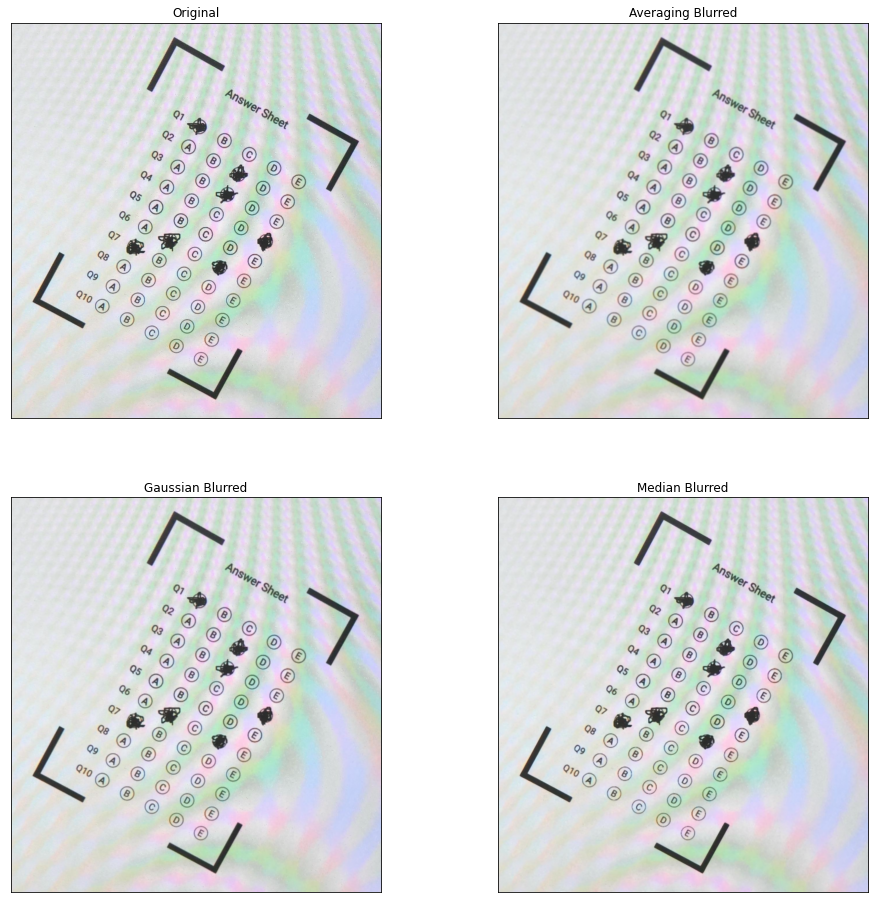

In [7]:
k_size = 5
filter_size = (k_size, k_size)
image = cv2.imread('data/answered-sheet-dropped.jpg')

# Averaging blurring
averaging_filter = create_averaging_filter(filter_size)
averaging_blurred_image = cv2.filter2D(image, -1, averaging_filter)
# Or you can simply use cv2.blur
# averaging_blurred_image = cv2.blur(image, filter_size)

# Gaussian blurring
gaussian_filter = create_gaussian_filter(filter_size)
gaussian_blurred_image = cv2.filter2D(image, -1, gaussian_filter)
# Or you can simply use cv2.GaussianBlur
# gaussian_blurred_image = cv2.GaussianBlur(image, filter_size, 0)

# Median blurring
median_blurred_image = cv2.medianBlur(image, k_size)

plt.rcParams['figure.figsize'] = [16, 16] # default: [6, 4]
draw_image(221, image, 'Original')
draw_image(222, averaging_blurred_image, 'Averaging Blurred')
draw_image(223, gaussian_blurred_image, 'Gaussian Blurred')
draw_image(224, median_blurred_image, 'Median Blurred')
plt.show()

# Normalize

Normalization is a process that changes the range of pixel intensity values, for example: transform the image's grayscale value range from [96, 128] to [0. 255].

**Example:**

We have an original image with have grayscale values in range [7, 255], and we need to change values range to [0, 255]. This script converts an original image to an grayscale image, and nomalizes the converted image.

In [8]:
def normalize(image):
    return cv2.normalize(image, np.zeros(image.shape), 0, 255, norm_type=cv2.NORM_MINMAX)

Grayscale value range in the original image [7, 255]
Grayscale value range in the normalized image [0, 255]


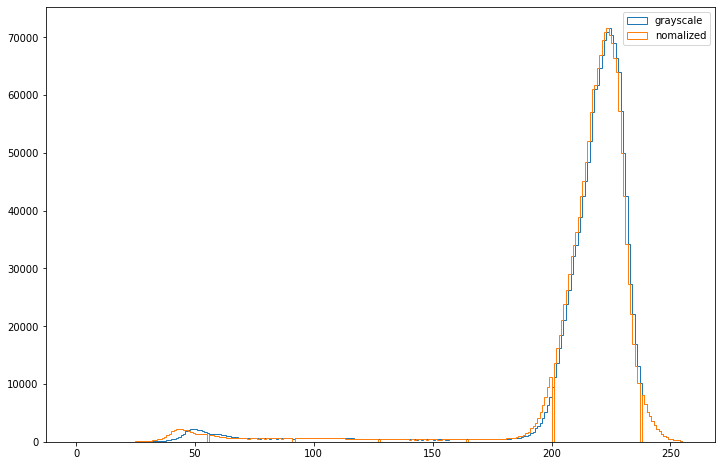

In [9]:
image = cv2.imread('data/answered-sheet-dropped.jpg')

grayscale_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
print('Grayscale value range in the original image [{}, {}]'
      .format(np.amin(grayscale_image), np.amax(grayscale_image)))

nomalized_image = normalize(grayscale_image)
print('Grayscale value range in the normalized image [{}, {}]'
      .format(np.amin(nomalized_image), np.amax(nomalized_image)))

plt.rcParams['figure.figsize'] = [12, 8]
plt.hist(grayscale_image.ravel(), 256, [0, 256], histtype='step', label='grayscale')
plt.hist(nomalized_image.ravel(), 256, [0, 256], histtype='step', label='nomalized')
plt.legend()
plt.show()

# Threshold

Thresholding is a process that converts pixel color to white or black, based on a threshold value.

**Example:**

Base on the normalized grayscale image, we get the thresholded image via this script:

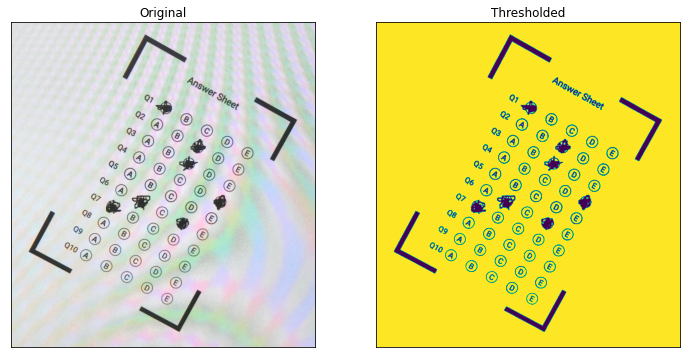

In [10]:
def threshold(image):
    _, thresholded_image = cv2.threshold(nomalized_image, 127, 255, cv2.THRESH_BINARY)
    return thresholded_image


thresholded_image = threshold(nomalized_image)

draw_image(121, image, 'Original')
draw_image(122, thresholded_image, 'Thresholded')
plt.show()

# Find contours

This step find contours from an grayscale image. To do this step, we apply the algorithm that is published in 1985 by Suzuki, S. and Abe, K. [2].

In [11]:
def get_contours(grayscale_image, use_approximating=True):
    contours, hierarchy = cv2.findContours(
        grayscale_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    if use_approximating:
        return list(map(get_approximated_contour, contours))
    
    return contours


def get_approximated_contour(contour, tol=.01):
    """Get rid of 'useless' points in the contour"""
    epsilon = tol * cv2.arcLength(contour, True)
    return cv2.approxPolyDP(contour, epsilon, True)

**Example:**

Assume we have an very noise image:

In [12]:
noise_image = cv2.imread('data/pic2.png')

Without bluring, we receive too many contours:

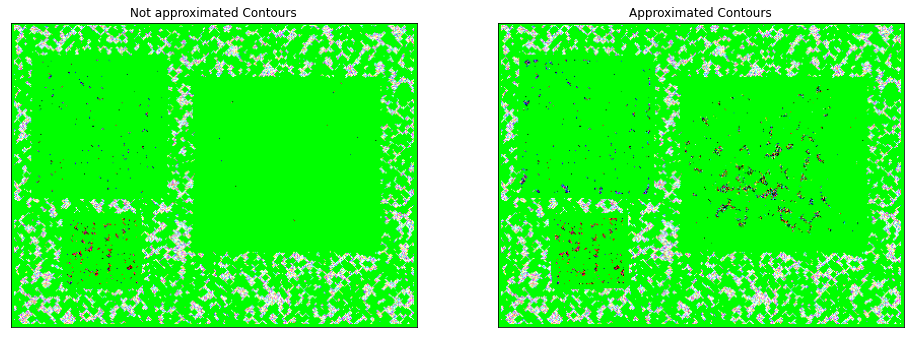

In [13]:
grayscale_image = cv2.cvtColor(noise_image, cv2.COLOR_BGR2GRAY)
nomalized_image = normalize(grayscale_image)
thresholded_image = threshold(nomalized_image)

not_approximated_contours = get_contours(thresholded_image, False)
approximated_contours = get_contours(thresholded_image)

copied_image_1 = noised_image.copy()
copied_image_2 = noised_image.copy()
cv2.drawContours(copied_image_1, not_approximated_contours, -1, (0, 255, 0), 3)
cv2.drawContours(copied_image_2, approximated_contours, -1, (0, 255, 0), 3)

plt.rcParams['figure.figsize'] = [16, 16] # default: [6, 4]
draw_image(121, copied_image_1, 'Not approximated Contours')
draw_image(122, copied_image_2, 'Approximated Contours')
plt.show()

When we applied blurring, the finding contours process is more accurate:

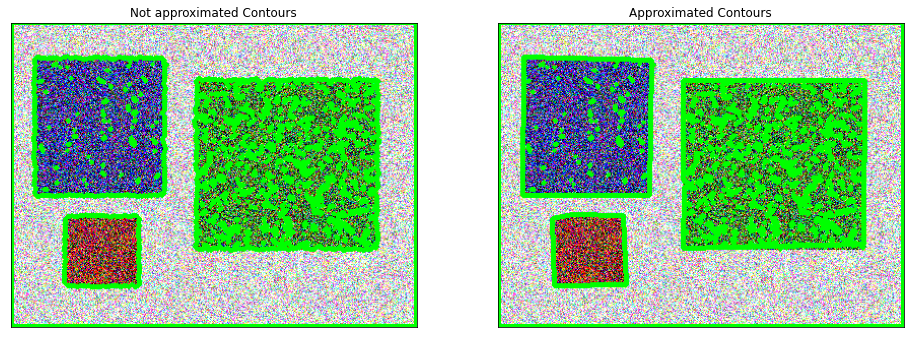

In [14]:
median_blurred_image = cv2.medianBlur(noised_image, 5)
grayscale_image = cv2.cvtColor(median_blurred_image, cv2.COLOR_BGR2GRAY)
nomalized_image = normalize(grayscale_image)
thresholded_image = threshold(nomalized_image)

not_approximated_contours = get_contours(thresholded_image, False)
approximated_contours = get_contours(thresholded_image)

copied_image_1 = noised_image.copy()
copied_image_2 = noised_image.copy()
cv2.drawContours(copied_image_1, not_approximated_contours, -1, (0, 255, 0), 3)
cv2.drawContours(copied_image_2, approximated_contours, -1, (0, 255, 0), 3)

plt.rcParams['figure.figsize'] = [16, 16] # default: [6, 4]
draw_image(121, copied_image_1, 'Not approximated Contours')
draw_image(122, copied_image_2, 'Approximated Contours')
plt.show()


# Find corners

## Calculate ratios

### Calculate contour area ratio with convex hull

In [15]:
def get_contour_area_ratio_with_convex_hull(contour):
    try:
        return (cv2.contourArea(contour) /
                cv2.contourArea(get_convex_hull(contour)))
    except:
        return np.inf


def get_convex_hull(contour):
    return cv2.convexHull(contour)

### Calculate contour area ratio with bouding box

In [16]:
def get_contour_area_ratio_with_bounding_box(contour):
    try:
        return (cv2.contourArea(contour) /
                cv2.contourArea(get_bounding_rectangle(contour)))
    except:
        return np.inf


def get_bounding_rectangle(contour):
    rect = cv2.minAreaRect(contour)
    box = cv2.boxPoints(rect)
    return np.int0(box)

### Calculate contour perimeter ratio with convex hull

In [17]:
def get_contour_perimeter_ratio_with_convex_hull(contour):
    return (cv2.arcLength(contour, True) /
            cv2.arcLength(get_convex_hull(contour), True))

### Calcuate contour perimeter ratio with bouding box

In [18]:
def get_contour_perimeter_ratio_with_bounding_box(contour):
    return (cv2.arcLength(contour, True) /
            cv2.arcLength(get_bounding_rectangle(contour), True))

## Find corners

In [19]:
CORNER_FEATURES = (
    0.322965313273202,
    0.19188334690998524,
    1.1514327482234812,
    0.998754685666376,
)


def get_corners(contours):
    return sorted(contours,
                  key=lambda c: features_distance(CORNER_FEATURES, get_features(c)))[:4]


def features_distance(f1, f2):
    return np.linalg.norm(np.array(f1) - np.array(f2))


def get_features(contour):
    try:
        return (
            get_contour_area_ratio_with_convex_hull(contour),
            get_contour_area_ratio_with_bounding_box(contour),
            get_contour_perimeter_ratio_with_convex_hull(contour),
            get_contour_perimeter_ratio_with_bounding_box(contour),
        )
    except:
        return 4 * [np.inf]

## Example

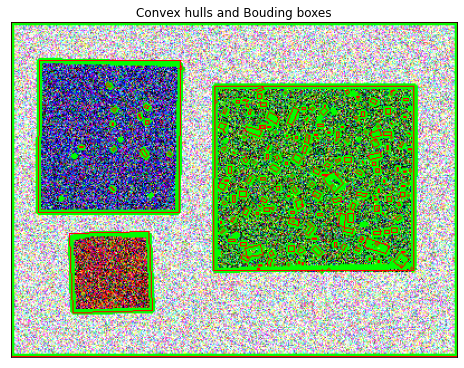

In [20]:
convex_hulls = []
bouding_boxes = []

for contour in approximated_contours:
    if get_contour_area_ratio_with_convex_hull(contour) != np.inf:
        convex_hulls.append(get_convex_hull(contour))
    if get_contour_area_ratio_with_bounding_box(contour) != np.inf:
        bouding_boxes.append(get_bounding_rectangle(contour))

copied_image_3 = noised_image.copy()
cv2.drawContours(copied_image_3, convex_hulls, -1, (0, 255, 0), 3)
cv2.drawContours(copied_image_3, bouding_boxes, -1, (255, 0, 0), 1)

plt.rcParams['figure.figsize'] = [8, 8] # default: [6, 4]
draw_image(111, copied_image_3, 'Convex hulls and Bouding boxes')
plt.show()

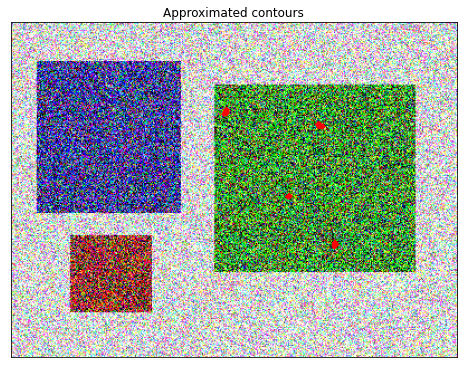

In [21]:
corners = get_corners(approximated_contours)

copied_image_4 = noised_image.copy()
cv2.drawContours(copied_image_4, corners, -1, (255, 0, 0), 3)
plt.rcParams['figure.figsize'] = [8, 8] # default: [6, 4]
draw_image(111, copied_image_4, 'Approximated contours')
plt.show()

# Find outmost points and do perspective transform 

In [22]:
def get_outmost_points(contours):
    all_points = np.concatenate(contours)
    return order_points(get_bounding_rectangle(all_points))


def order_points(points):
    """Order points counter-clockwise-ly."""
    origin = np.mean(points, axis=0)

    def positive_angle(p):
        x, y = p - origin
        ang = np.arctan2(y, x)
        return 2 * np.pi + ang if ang < 0 else ang

    return sorted(points, key=positive_angle)

# Perspective transform

In [23]:
def perspective_transform(image, points):
    src_rectangle = np.array(points, dtype='float32')
    (tl, tr, br, bl) = src_rectangle
    
    # compute the width of the new image, which will be the
    # maximum distance between bottom-right and bottom-left
    # x-coordiates or the top-right and top-left x-coordinates
    width_a = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    width_b = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    max_width = max(int(width_a), int(width_b))
    
    # compute the height of the new image, which will be the
    # maximum distance between the top-right and bottom-right
    # y-coordinates or the top-left and bottom-left y-coordinates
    height_a = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    height_b = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    max_height = max(int(height_a), int(height_b))
    
    dest_rectangle = np.array(
        [[max_width - 1, max_height - 1],
         [0, max_height - 1],
         [0, 0],
         [max_width - 1, 0]],
        dtype = 'float32')
        
    transform = cv2.getPerspectiveTransform(src_rectangle, dest_rectangle)
    warped = cv2.warpPerspective(image, transform, (max_width, max_height))
    return warped

**Example:**

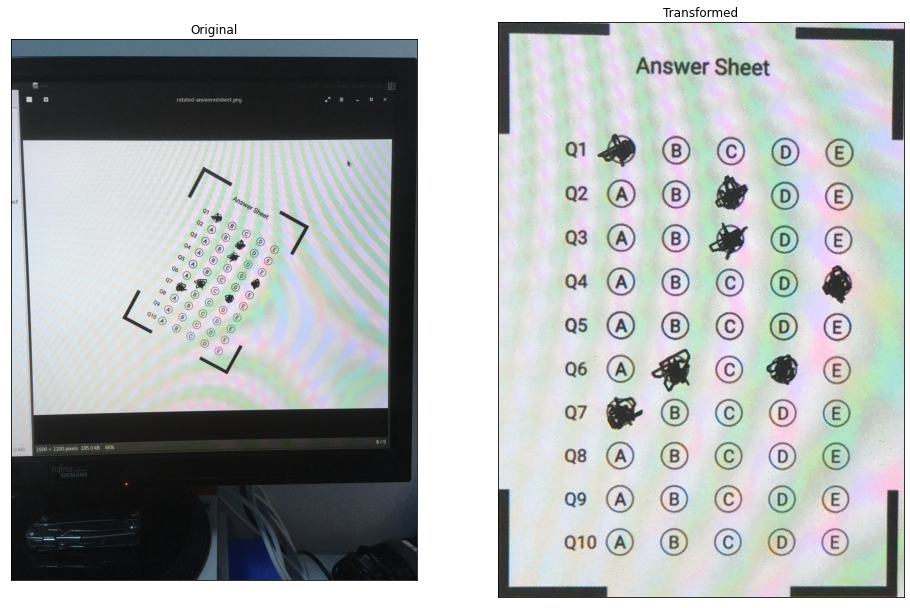

In [24]:
image = cv2.imread('data/answered-sheet.jpg')

blurred_image = cv2.GaussianBlur(image, (11, 11), 10)
grayscale_image = cv2.cvtColor(blurred_image, cv2.COLOR_BGR2GRAY)
nomalized_image = normalize(grayscale_image)
thresholded_image = threshold(nomalized_image)

contours = get_contours(thresholded_image)

corners = get_corners(contours)
outmost_points = get_outmost_points(corners)

transformed_image = perspective_transform(image, outmost_points)

plt.rcParams['figure.figsize'] = [16, 16] # default: [6, 4]
draw_image(121, image, 'Original')
draw_image(122, transformed_image, 'Transformed')
plt.show()


# Scan each line for the marked answer

In [25]:
OPTION_SIZE = 40


def get_question_answers(thresholded_image, question):
    question_answers = []
    for i in range(5):
        shaded = is_shaded(thresholded_image, question, i)
        if shaded:
            question_answers.append(i)
    return question_answers

        
def is_shaded(thresholded_image, question, option):
    cw = thresholded_image.shape[1] / 500
    ch = thresholded_image.shape[0] / 707
    
    y = int((135 + 55 * question) * ch)
    x = int((135 + 65 * option) * cw)
    roi = thresholded_image[y:(y + int(OPTION_SIZE * ch)),
                            x:(x + int(OPTION_SIZE * cw))]
    roi = roi.ravel()
    n_shaded = sum(roi == 0)
    return (n_shaded / roi.shape[0]) >= 0.3

In [27]:
transformed_thresholded_image = perspective_transform(thresholded_image, outmost_points)

for i in range(10):
    question_answers = get_question_answers(transformed_thresholded_image, i)
    answer = 'empty'
    if len(question_answers) > 0:
        answer = ', '.join([chr(ord('A') + question_answer)
                            for question_answer in question_answers])
    print(i + 1, answer)

1 A
2 C
3 C
4 E
5 empty
6 B, D
7 A
8 empty
9 empty
10 empty


# References

[1]: https://www.tandfonline.com/doi/abs/10.3810/pgm.1998.08.550
[2]: https://docs.opencv.org/2.4/modules/imgproc/doc/structural_analysis_and_shape_descriptors.html?highlight=findcontours#findcontours